[View in Colaboratory](https://colab.research.google.com/github/pamsfwang/perceptual_learning/blob/master/stochastic_stimuli.ipynb)

In [0]:
import tensorflow as tf
import numpy
import os
import pandas as pd
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt




In [2]:
#Mount Google drive on Colab
#step01
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


from google.colab import auth
auth.authenticate_user()

from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
#step02: code for mounting google drive on Linux
!mkdir -p drive
!google-drive-ocamlfuse drive

#step03: change directory to the google drive folder for the project
os.getcwd()
!ls
os.chdir('./drive/Colab_files')
os.getcwd()
!ls

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.
datalab  drive
drive			     notebooks
jfj_stimuli_param.csv	     stimuli_param_uniqueF3.csv
jfj_stimuli_param_test.csv   stimuli_param_uniqueF3_test_new.csv
jfj_stimuli_param_train.csv  stimuli_param_uniqueF3_train_new.csv
models			     stimuli_param_uniqueF3_train_new.csv.ods


In [0]:
#specify variables
train_data = 'stimuli_param_uniqueF3_train_new.csv' #'jfj_stimuli_param_train.csv'
test_data = 'stimuli_param_uniqueF3_test_new.csv'# 'jfj_stimuli_param_test.csv'

num_features = 3
node_hidden01 = 10
learning_rate = 0.005
initial_weight01 = -0.001
initial_weight02 = 0.001

In [10]:
#load data
df=pd.read_csv(train_data, sep=',',header=None)
df.shape
nsamples =df.shape[0]
print "number of training samples:",nsamples

#shuffle the data
df_array = df.values
new = numpy.take(df_array,numpy.random.permutation(df_array.shape[0]),axis=0,out=df_array);

##separate data into features and labels (numpy.array)
temp = new[:,0:num_features] #df.iloc[:,0:num_features]
x_data = temp #temp.values
print "dimension of feature dataset:",x_data.shape
print(x_data[0:5,:])

temp = new[:,3]#df.iloc[:,num_features]
y_data = temp #temp.values
print "dimension of category dataset:",y_data.shape
print(y_data[0:5])


#load test data
df=pd.read_csv(test_data, sep=',',header=None)
df.shape
print "number of test samples:",df.shape[0]

##separate data into features and labels (numpy.array)
temp = df.iloc[:,0:num_features]
test_x_data = temp.values
print "dimension of feature dataset:",test_x_data.shape
print(test_x_data)

temp = df.iloc[:,num_features]
test_y_data = temp.values
print "dimension of category dataset:",test_y_data.shape
print(test_y_data)

number of training samples: 52
dimension of feature dataset: (52, 3)
[[3.  4.  3.6]
 [2.  2.  3. ]
 [1.  1.  2.2]
 [1.  3.  3.1]
 [2.  1.  2.7]]
dimension of category dataset: (52,)
[0. 1. 1. 1. 1.]
number of test samples: 16
dimension of feature dataset: (16, 3)
[[1.  0.  1.2]
 [1.  1.  4.2]
 [2.  0.  5.7]
 [2.  1.  1.8]
 [2.  4.  5.7]
 [3.  0.  2.1]
 [3.  1.  5.3]
 [4.  0.  5.7]
 [1.  4.  4.2]
 [2.  3.  0. ]
 [2.  4.  1.8]
 [3.  3.  4.2]
 [3.  4.  1.6]
 [3.  0.  1.1]
 [4.  3.  6.2]
 [4.  4.  4.2]]
dimension of category dataset: (16,)
[1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]


In [44]:
#logistic regression
logisticRegr = LogisticRegression()
logisticRegr.fit(x_data, y_data)
predictions = logisticRegr.predict(test_x_data)

acc = []
temp = predictions+test_y_data
for ii in xrange(len(temp)):
  if temp[ii] ==2 or temp[ii]==0:
    acc.append(1)
  else:
    acc.append(0)
    
accuracy_per = float(sum(acc))/float(len(acc))
print("calculate accuracy :" + repr(accuracy_per))
#print(len(acc))
#print(acc)
score = logisticRegr.score(test_x_data, test_y_data)
print(score)



[2. 2. 2. 2. 1. 2. 2. 2. 0. 1. 0. 0. 0. 1. 0. 0.]
calculate accuracy :0.8125
0.8125


In [0]:
##set up network layers
#You can think of most the tensorflow variables as actually being functions that we will call when we want to get their value. 
input_ph = tf.placeholder(tf.float32, shape=[num_features,1]) 
#This will be the place the input to the network is inserted
#shape: number of features

target_ph =  tf.placeholder(tf.float32, shape=[1,1]) 
#This will be the place the target for the network is insertedd
#shape = number of node

#First layer weights
W1 = tf.Variable(tf.random_uniform([node_hidden01,num_features],initial_weight01,initial_weight02)) 
#first layer: 3 input feautres to 10 nodes in the hidden layer

b1 = tf.Variable(tf.random_uniform([node_hidden01,1],initial_weight01,initial_weight02)) # " " biases
#one bias to the 10 nodes in the hidden layer
#[# nodes, # nodes], sampling from a random uniform distribution from -1 to 1 for initial weights

#2nd layer
W2 = tf.Variable(tf.random_uniform([1,node_hidden01],initial_weight01,initial_weight02)) 
#second layer: 10 nodes in the first hidden layer to one node in the second
b2 = tf.Variable(tf.random_uniform([1],initial_weight01,initial_weight02))


#####

##construct the network
h1 = tf.nn.tanh(tf.matmul(W1,input_ph)+b1)
#y = tanh(x1w11+x2w21)
#tf.matmul: matrix multiplication

output = tf.nn.sigmoid(tf.matmul(W2,h1)+b2) 
#This is the actual construction of the network. 
#When we want to get the output of the network, we will tell tensorflow what to put in the input placeholder, and then we'll run this output function

loss = tf.reduce_sum(tf.square(output - target_ph))
#This is the function we're trying to optimize. The reduce_sum is not really necessary since we only have a single output, just using it to flatten the output.

#optimizer = tf.train.AdamOptimizer(learning_rate) 
optimizer = tf.train.AdamOptimizer(learning_rate)
#This is a fancy version of momentum based gradient descent optimization.

train = optimizer.minimize(loss) 
#This will be how we tell the network to train on an example


In [0]:
def test():
    MSE = 0.0
    for i in xrange(len(x_data)):
      MSE += sess.run(loss,feed_dict={input_ph: x_data[i].reshape([num_features,1]),target_ph: y_data[i].reshape([1,1])}) #test on a test data point. feed_dict is how you pass things in to the placeholders created above
    MSE /= len(x_data)
    return MSE

def accuracy():
    temp =[] 
    acc=[]
    for i in xrange(len(x_data)):
        temp.append(sess.run(output,feed_dict={input_ph: x_data[i].reshape([num_features,1])}))
    
    #t2 = temp+y_data
    #for ii in xrange(len(t2)):
    #  if t2[ii] ==2 or t2[ii]==0:
    #    acc.append(1)
    #  else:
    #    acc.append(0)
    #accuracy_per = float(sum(acc))/float(len(acc)) 
    return temp #accuracy_per
    
    
def hidden():
    temp = []
    for i in xrange(len(y_data)):
        temp.append(sess.run(h1,feed_dict={input_ph: x_data[i].reshape([num_features,1])}))
    return temp

In [49]:
# Launch the graph -- tell tensorflow to initialize everything.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) #first argument to sess.run is function to run, here we're running the initialize function

# Fit the function
print "Pre training MSE:", test
ac = []
hid = []
los = []
for step in xrange(1):
  #load data
  df=pd.read_csv(train_data, sep=',',header=None)
#shuffle the data
  df_array = df.values
  new = numpy.take(df_array,numpy.random.permutation(df_array.shape[0]),axis=0,out=df_array);
##separate data into features and labels (numpy.array)
  x_data = new[:,0:num_features] #features
  y_data = new[:,3] #labels
  for item in xrange(nsamples):
    sess.run(train,feed_dict={input_ph: x_data[item].reshape([num_features,1]),target_ph: y_data[item].reshape([1,1])}) 
  #Run training on an example
  ac.append(accuracy())
  hid.append(hidden())
  los.append(test())
  if step % 100 == 0:
    print "On step %i, test MSE %f" %(step,test())

Pre training MSE: <function test at 0x7f667e27ec80>
On step 0, test MSE 0.249651


In [59]:
print "Post training MSE:", test()
print "Final weights:"
#print(sess.run(W1),sess.run(b1),sess.run(W2),sess.run(b2))
print(ac[0])

Post training MSE: 0.24965073712743246
Final weights:
[array([[0.49675792]], dtype=float32), array([[0.49651313]], dtype=float32), array([[0.4945361]], dtype=float32), array([[0.49549326]], dtype=float32), array([[0.4960027]], dtype=float32), array([[0.49593356]], dtype=float32), array([[0.49563414]], dtype=float32), array([[0.49572706]], dtype=float32), array([[0.49469638]], dtype=float32), array([[0.49726182]], dtype=float32), array([[0.49458987]], dtype=float32), array([[0.49518275]], dtype=float32), array([[0.49487486]], dtype=float32), array([[0.49616915]], dtype=float32), array([[0.49595273]], dtype=float32), array([[0.49554735]], dtype=float32), array([[0.49527404]], dtype=float32), array([[0.49584198]], dtype=float32), array([[0.4970009]], dtype=float32), array([[0.4956898]], dtype=float32), array([[0.49663147]], dtype=float32), array([[0.49737126]], dtype=float32), array([[0.4957315]], dtype=float32), array([[0.4966605]], dtype=float32), array([[0.4962608]], dtype=float32), ar

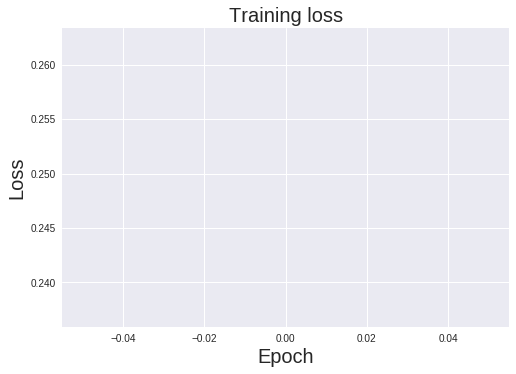

IndexError: ignored

In [60]:
#fig, axes = plt.subplots(2, sharex=True, figsize=(18, 9))
#fig.suptitle('Training Metrics')

#axes[0].set_ylabel("Loss", fontsize=20)
#axes[0].set_xlabel("epoch", fontsize = 20)
#axes[0].plot(los)

#axes[1].set_ylabel("Accuracy", fontsize=14)
#axes[1].set_xlabel("Epoch", fontsize=14)
#axes[1].plot(ac)
#plt.show()


plt.plot(los)
plt.ylabel('Loss', fontsize = 20)
plt.xlabel('Epoch',fontsize = 20)
plt.title('Training loss', fontsize = 20)
plt.show()

plt.imshow(hid[1][2],cmap=plt.cm.BuPu_r)
plt.colorbardw
plt.show()

In [0]:
len(ac[1])


In [177]:
a = numpy.array([3, 5,7,6])
print(a[1:2])
  

[5]


In [5]:
#load test data
df=pd.read_csv(test_data, sep=',',header=None)
df.shape
print "number of test samples:",df.shape[0]

##separate data into features and labels (numpy.array)
temp = df.iloc[:,0:num_features]
test_x_data = temp.values
print "dimension of feature dataset:",test_x_data.shape
print(test_x_data)

temp = df.iloc[:,num_features]
test_y_data = temp.values
print "dimension of category dataset:",test_y_data.shape
print(test_y_data)

number of test samples: 8
dimension of feature dataset: (8, 3)
[[1 1 2]
 [2 1 2]
 [3 3 2]
 [4 3 2]
 [1 3 2]
 [2 3 2]
 [3 1 2]
 [4 1 2]]
dimension of category dataset: (8,)
[1 1 1 1 0 0 0 0]


In [33]:
# Launch the graph -- tell tensorflow to initialize everything.
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init) #first argument to sess.run is function to run, here we're running the initialize function

# Fit the function
print "Pre training MSE:", test
ac = []
hid = []
los = []
for step in xrange(600):
  for item in xrange(nsamples):
    #sess.run(train,feed_dict={input_ph: x_data[item].reshape([3,1]),target_ph: y_data[item].reshape([1,1])}) 
  sess.run(train,feed_dict={input_ph: x_data[step % nsamples].reshape([num_features,1]),target_ph: y_data[step % nsamples].reshape([1,1])}) 
  #sess.run(train): this will train the model, update the weights
  #Run training on an example
  ac.append(accuracy())
  hid.append(hidden())
  los.append(test())
  if step % 100 == 0:
    print "On step %i, test MSE %f" %(step,test())

IndentationError: ignored